In [123]:
import matplotlib.pyplot as plt 
from particles.collectors import Moments

Yahoo fin S&P 500 scraping

Then, in the directory of the project run `python src/yahooscraper.py` to begin the scraping.

First implementation of the model

The model studied in the section 4. of the paper is defined as: $$ y^i_t = W^i_t \cdot \beta ^i _y + \gamma _y^i \cdot \delta ^i_t + \sqrt{\delta ^i_t} \cdot \exp(\frac{h^i_t} 2) \cdot \epsilon ^i_{y, t}$$ $$ h^i_{t+1} = \mu_h ^i + \phi_h ^i \cdot (h_t^i - \mu_h ^i)+ \sigma _h ^i \cdot \epsilon _{h,t} ^i $$
where $$ \epsilon ^i_{\cdot, t} \sim \mathcal N(0,1)$$ $$\delta ^i _t \sim \text{Inv-Gamma}(\frac{\nu_y ^i} 2, \frac{\nu_y ^i} 2)$$ $$W^i _t = (1, y^i_{t-1}, \dots, y^i_{t-k}) $$ with $k=3, 5$ depending on the type of the series studied ($3$ for equities series and $5$ for credit default swap series). We assume moreover that $$\text{Corr}(\epsilon ^i_{y, t}, \epsilon ^i_{h, t}) = \rho^i$$

The different indices respectively are:
1. $i$: the index of the time series.
2. $t$: the date of observation of the stochastic process.
3. $h$ and $y$: if whether the variable is associated to the state $h$ or the observation $y$.

**Remarks on the model**: 
- The observations are $y^i_t$ which is the log-return of the $i$-th observed time series at time $t$.
- The state variable is $(h^i_t, \delta^i_t)$ which is associated to the observation $y^i_t$.
- The article models the logreturns as SV (Stochastic Volatility) processes, $h$ can be associated with the volatility associated to $\exp(y^i_\cdot)$.

The priors of the parameters are:
- $\mu_h^i \sim \mathcal N(0.4, 2)$
- $\phi _h ^i \sim \mathcal N(0.985, 0.001)$
- $(\sigma ^i _h )^2 \sim \text{Inv Gamma}(20, 0.25)$

## 'Rough' Simulation of the model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma

def SV(T, mu_h, phi_h, sigma_h, rho, nu_y, beta_y, gamma_y):
    h = np.ones(T)
    y = np.ones(T)
    cov = np.array([[1, rho], [rho, 1]])
    for t in range (T-1):
        delta = invgamma.rvs(nu_y/2, scale=nu_y/2)
        eps = np.random.multivariate_normal([0, 0], cov)

        eps_y = eps[0]
        eps_h = eps[1]
        
        h[t+1] = mu_h + phi_h * (h[t] - mu_h) + sigma_h * eps_h

        W = []
        for lag in range(4):
            if t - lag >= 0:
                W.append(y[t-lag])
            else:
                W.append(0)
        W[0] = 1.0  # intercept
        W = np.array(W)

        y[t] = W.T @ beta_y + gamma_y * delta + np.sqrt(delta) * np.exp(h[t]/2) * eps_y

    return h, y

np.random.seed(42)

T = 2000

mu_h = -1.0
phi_h = 0.9
sigma_h = 0.1
rho = 0.8
nu_y = 8.0
beta_y = np.array([0, 0.1, 0.1, 0.5])
gamma_y = 0.05

h, y = SV(T, mu_h, phi_h, sigma_h, rho, nu_y, beta_y, gamma_y)

print(np.mean(y))

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(y, label="Log Returns", linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Stochastic Volatility Simulation (Fixed Parameters)')
plt.legend()
plt.show()

## Simulation using particles

In [126]:
# imports from the package
import particles
import numpy as np
from particles import state_space_models as ssms
from particles import distributions as dists

class SV(ssms.StateSpaceModel):
    """ Theta-Logistic state-space model (used in Ecology).
    """
    default_params = {'mu_h':.15, 
                      'phi_h':.8, 
                      'sigma_h': .1, 
                      'rho_h': 0.3, 
                      'beta_y': [0.1, 0.4, 0.1, 0.1],
                      'gamma_y': .05,
                      'nu_y': 8.0
    }

    def PX0(self):  # Distribution of X_0
        return dists.IndepProd(dists.Dirac(0),
                               dists.Dirac(4/3),
                               )

    def PX(self, t, xp):  #  Distribution of X_t given X_{t-1} = xp (p=past)
        return dists.IndepProd(
            dists.Normal(loc=self.mu_h + self.phi_h * (xp[:, 0] - self.mu_h), scale=self.sigma_h),
            dists.InvGamma(a=self.nu_y/2, b=self.nu_y/2)
        )

    def PY(self, t, xp, x):  # Observation model
        if hasattr(self, 'data') and t >= 3:
            y_t_1 = self.data[t - 1]
            y_t_2 = self.data[t - 2]
            y_t_3 = self.data[t - 3]
        else:
            # Use default values or dummy covariates during simulation
            y_t_1, y_t_2, y_t_3 = 0, 0, 0
        
        intercept = 1
        W = np.array([intercept, y_t_1, y_t_2, y_t_3])
        return dists.Normal(loc=self.beta_y @ W + self.gamma_y * x[:, 1], 
                            scale=np.sqrt(x[:, 1]) * np.exp(x[:, 0] / 2))

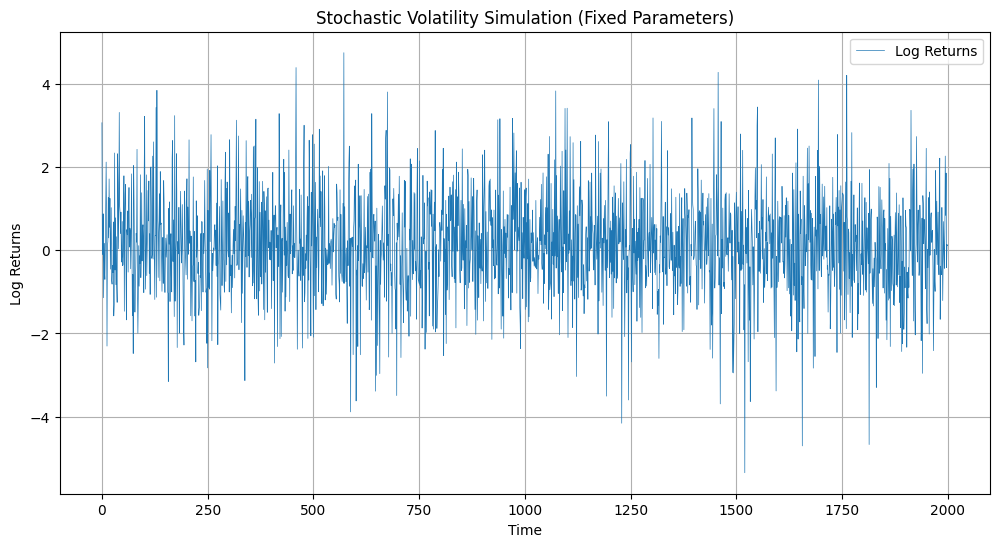

In [127]:
np.random.seed(42)
model = SV()
X, y = model.simulate(2000)
plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(y, label="Log Returns", linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Stochastic Volatility Simulation (Fixed Parameters)')
plt.legend()


## Importing real data for bootstraping

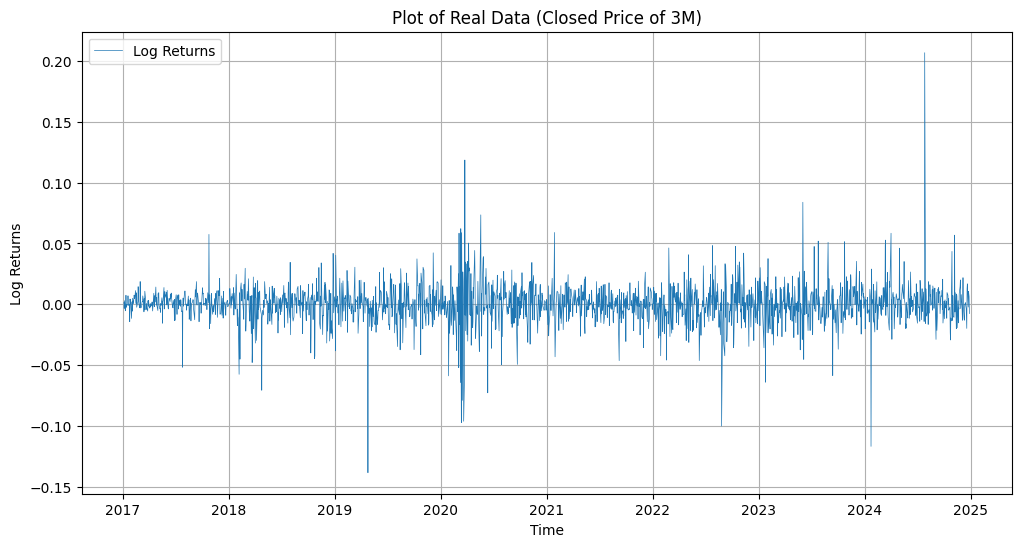

In [128]:
import pandas as pd

prices = pd.read_csv('data/sp500_prices.csv')
prices['Date'] = pd.to_datetime(prices['Date'])

company = prices['Company'].drop_duplicates().values[0]
ex_prices = prices[prices['Company'] == company][['Date', 'Close']]

price = ex_prices['Close'].values
logreturns = np.log(price[1:]/ price[:-1])
dates = ex_prices['Date'].values[1:]

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(dates, logreturns, label="Log Returns", linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title(f'Plot of Real Data (Closed Price of {company})')
plt.legend()

## Implementing Bootstrap algorithm to evaluate likelihood

In [134]:
from particles import SMC

fk_boot = ssms.Bootstrap(ssm=model, data=logreturns)
pf = SMC(fk=fk_boot, N=1000, collect=[Moments()])
pf.run()

log_likelihood = pf.logLt
print("Log-Likelihood of the real data:", log_likelihood)

Log-Likelihood of the real data: -2021.076484254403


/var/folders/pg/mh4np6_d0qs9cxq5clx1wbbw0000gn/T/ipykernel_9657/808141085.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


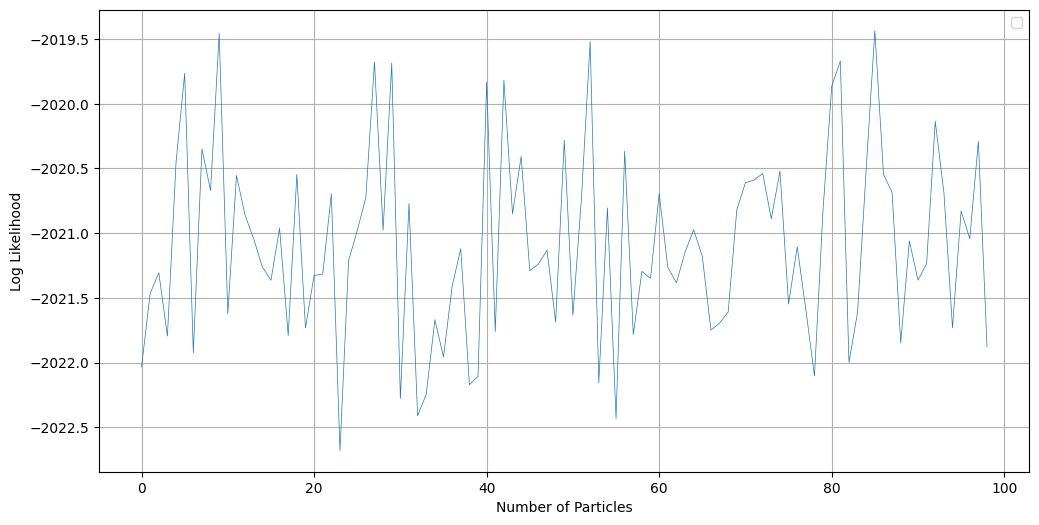

In [135]:
fk_boot = ssms.Bootstrap(ssm=model, data=logreturns)

logl = []

for k in range(100, 100*100, 100):
    pf = SMC(fk=fk_boot, N=1000, collect=[Moments()])
    pf.run()
    logl.append(pf.logLt)

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(logl, linewidth=0.5)
plt.xlabel('Number of Particles')
plt.ylabel('Log Likelihood')
plt.legend()

## Parameter estimation